In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms
import torchaudio.functional
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
from collections import OrderedDict
import psutil  # For monitoring memory usage
from torch.nn.functional import cosine_similarity
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from tqdm import tqdm
from torchsummary import summary
from skimage.transform import resize

sys.path.append('SVEVAE')
from SVEVAE.sve_vae import SVE_VAE
print("Switched back to:", os.getcwd())

Switched back to: C:\Users\James Lee\Desktop\Course\MachineLearningMusic\project


In [2]:
# Ensure device is set
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def parse_wav_files(base_dir):
    """
    Parse all .wav files and organize them into a dictionary.

    Args:
        base_dir (str): The base directory containing singers' folders.

    Returns:
        dict: A dictionary with keys as "{song_name + technique}" and values as "{singer, technique, file_path (list)}".
    """
    singers_data = {
        "ZH-Alto-1": "Singer_Alto",
        "ZH-Tenor-1": "Singer_Tenor"
    }

    wav_dict = {}

    for singer_folder, singer_name in singers_data.items():
        singer_path = os.path.join(base_dir, "Chinese", singer_folder)

        # Traverse through techniques
        for technique in os.listdir(singer_path):
            technique_path = os.path.join(singer_path, technique)

            if not os.path.isdir(technique_path):
                continue

            # Traverse through song names
            for song_name in os.listdir(technique_path):
                song_path = os.path.join(technique_path, song_name)

                if not os.path.isdir(song_path):
                    continue

                # Traverse through groups
                for group in os.listdir(song_path):
                    group_path = os.path.join(song_path, group)

                    if not os.path.isdir(group_path):
                        continue

                    # Traverse .wav files in the group
                    for file_name in os.listdir(group_path):
                        if file_name.endswith(".wav"):
                            file_path = os.path.join(group_path, file_name)
                            key = f"{song_name}_{technique}"
                            
                            # Add to dictionary
                            if key not in wav_dict:
                                wav_dict[key] = {
                                    "singer": singer_name,
                                    "technique": technique,
                                    "file_path": []
                                }
                            
                            # Append file path to the list
                            wav_dict[key]["file_path"].append(file_path)

    return wav_dict

#################
base_directory = "."  # Replace with the actual path
wav_dict = parse_wav_files(base_directory)

# Remove file paths with "Paired_Speech_Group"
for key, value in wav_dict.items():
    value['file_path'] = [
        path for path in value['file_path']
        if "Paired_Speech_Group" not in path
    ]

# Display the results
for key, value in wav_dict.items():
    print(f"Key: {key}")
    print(f"Value: {value}")
#################

Key: 不再见_Breathy
Value: {'singer': 'Singer_Alto', 'technique': 'Breathy', 'file_path': ['.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0001.wav', '.\\Chinese\\ZH-

.\Chinese\ZH-Alto-1\Breathy\不再见\Breathy_Group\0000.wav


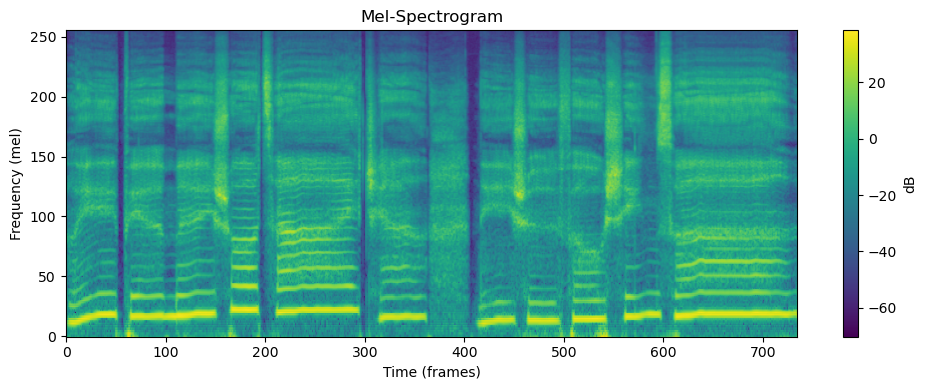

tensor([[[-11.8845,  -3.0180,   0.7324,  ...,  -2.2506,   2.6068,  -8.9338],
         [-18.7408,  -9.8744,  -6.1240,  ...,  -9.1070,  -4.2496, -15.7902],
         [-10.3552, -16.5805, -11.0850,  ...,  -7.7928,  -5.1620,  -5.3419],
         ...,
         [-55.2677, -56.0814, -54.2120,  ..., -48.8630, -48.4071, -46.7460],
         [-54.7133, -53.6548, -50.4647,  ..., -47.5093, -48.3156, -44.8831],
         [-52.8423, -53.1857, -52.5979,  ..., -44.4747, -48.0882, -48.2550]]])


In [4]:
def compute_mel_spectrogram(
    audio_path,
    sample_rate=48000,
    n_fft=2048,
    hop_length=512,
    n_mels=256,
    to_db=True,
    show_plot=False
):
    """
    Compute the mel-spectrogram of an audio file.
    
    Parameters:
        audio_path (str): Path to the audio file.
        sample_rate (int): Desired sample rate of the audio.
        n_fft (int): Number of FFT points.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of mel filter banks.
        to_db (bool): Whether to convert the spectrogram to decibel scale.
    
    Returns:
        torch.Tensor: Mel-spectrogram (in dB if to_db is True).
    """
    # Load audio file
    waveform, orig_sample_rate = torchaudio.load(audio_path)
    
    # Resample if necessary
    if orig_sample_rate != sample_rate:
        resampler = T.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
        waveform = resampler(waveform)
    
    # Create MelSpectrogram transform
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=35
    )
    
    # Compute the mel-spectrogram
    mel_spec = mel_spectrogram(waveform)
    
    # Convert to dB if required
    if to_db:
        db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')
        mel_spec = db_transform(mel_spec)
        
    # Visualize the mel-spectrogram
    if show_plot:
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='dB')
        plt.title('Mel-Spectrogram')
        plt.xlabel('Time (frames)')
        plt.ylabel('Frequency (mel)')
        plt.tight_layout()
        plt.show()
    
    return mel_spec

temp_filepath = wav_dict['不再见_Breathy']['file_path'][0]
print(temp_filepath)
mel_spec = compute_mel_spectrogram(temp_filepath, show_plot=True)
print(mel_spec)

In [5]:
def compute_global_min_max(data_dict, sample_rate=48000):
    
    global_min = float('inf')
    global_max = float('-inf')
    
    counter = 0

    for key, value in data_dict.items():
        file_paths = value["file_path"]

        for file_path in file_paths:
            
            if counter % 250 == 0:
                print(counter)
            
            # Compute mel-spectrogram for each file
            mel_spectrogram = compute_mel_spectrogram(file_path, sample_rate=sample_rate)

            # Update global min and max
            file_min = mel_spectrogram.min().item()
            file_max = mel_spectrogram.max().item()

            global_min = min(global_min, file_min)
            global_max = max(global_max, file_max)

            # Debugging/logging
            counter = counter + 1
            # print(f"[DEBUG] File: {file_path}, Min: {file_min}, Max: {file_max}")

    return global_min, global_max

# Compute global min and max
# global_mel_min, global_mel_max = compute_global_min_max(wav_dict)
# Min: -100.0, Max: 53.63450622558594
global_mel_min = -100.0
global_mel_max = 54
print(f"Global Mel-Spectrogram Min: {global_mel_min}, Max: {global_mel_max}")

Global Mel-Spectrogram Min: -100.0, Max: 54


In [6]:
# total 4080

class VocalTechniqueDataset(Dataset):
    def __init__(self, data_dict, sample_rate=48000, fixed_timesteps=196, step_size=10, 
                 global_mel_min=-100, global_mel_max=54, transform=None, num_duplicates=5):
        
        """
        Initializes the dataset.

        Args:
            data_dict (dict): Dictionary containing file paths for all techniques.
            sample_rate (int): Sample rate for loading audio.
            fixed_timesteps (int): Fixed number of timesteps for all samples.
            step_size (int): Step size for sequential sampling.
            transform (callable, optional): Transformation to apply to audio.
        """
        
        print("Initializing VocalTechniqueDataset")
        
        self.data_pairs = []
        self.sample_rate = sample_rate
        self.fixed_timesteps = fixed_timesteps
        self.step_size = step_size
        self.transform = transform
        self.global_mel_min = global_mel_min
        self.global_mel_max = global_mel_max

        # techniques list
        techniques = ["Breathy", "Glissando", "Mixed_Voice_and_Falsetto", "Pharyngeal", "Vibrato"]

        for key, value in data_dict.items():
            # Extract control and technique files
            control_files = [path for path in value["file_path"] if "Control_Group" in path]
            technique_files = [path for path in value["file_path"] if "Group" in path and "Control_Group" not in path]

            control_files_map = {os.path.basename(f): f for f in control_files}

            for technique_path in technique_files:
                filename = os.path.basename(technique_path)
                if filename in control_files_map:
                    control_path = control_files_map[filename]

                    # Extract the technique folder name of the target
                    target_technique_folder = os.path.basename(os.path.dirname(technique_path))  # e.g., Falsetto_Group

                    # Find references from other songs but the same technique
                    available_references = []
                    for other_key, other_value in data_dict.items():
                        if other_key != key:  # Ensure different songs
                            other_technique_files = [
                                path for path in other_value["file_path"]
                                if target_technique_folder in path  # Match exact technique folder
                            ]
                            available_references.extend(other_technique_files)

                    # Ensure enough references exist
                    if len(available_references) < num_duplicates:
                        raise ValueError(f"Not enough references for {technique_path} with technique {target_technique_folder}.")

                    # Select references
                    selected_references = random.sample(available_references, num_duplicates)
                    for reference_path in selected_references:
                        pair = (control_path, reference_path, technique_path)
                        self.data_pairs.append(pair)

                        # Debug print for clarity
                        print(f"Added pair: {pair}")
                        
            
    def __len__(self):
        return len(self.data_pairs)

    def sample_fixed_window(self, control_mel, reference_mel, technique_mel, target_timesteps = 256):
        """
        Randomly selects a window of 400 timesteps from all three mel-spectrograms.

        Args:
            control_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].
            reference_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].
            technique_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].

        Returns:
            torch.Tensor: Adjusted control mel-spectrogram of shape [n_mels, 400].
            torch.Tensor: Adjusted reference mel-spectrogram of shape [n_mels, 400].
            torch.Tensor: Adjusted technique mel-spectrogram of shape [n_mels, 400].
        """
        _, control_timesteps = control_mel.shape
        _, reference_timesteps = reference_mel.shape
        _, technique_timesteps = technique_mel.shape

        # Ensure all mel-spectrograms have enough timesteps
        min_timesteps = min(control_timesteps, reference_timesteps, technique_timesteps)
        if min_timesteps < target_timesteps:
            raise ValueError("All mel-spectrograms must have at least 400 timesteps.")

        # Randomly select a starting index for the window
        start_idx = random.randint(0, min_timesteps - target_timesteps)
        end_idx = start_idx + target_timesteps

        # Slice the window from each mel-spectrogram
        control_mel_window = control_mel[:, start_idx:end_idx]
        reference_mel_window = reference_mel[:, start_idx:end_idx]
        technique_mel_window = technique_mel[:, start_idx:end_idx]

        return control_mel_window, reference_mel_window, technique_mel_window
    
    def pitch_match(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        
        """
        Align the pitch of reference and target waveforms to match the control waveform.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor [1, time].
            reference_waveform (torch.Tensor): Reference waveform tensor [1, time].
            target_waveform (torch.Tensor): Target waveform tensor [1, time].
            sample_rate (int): Sampling rate of the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Pitch-aligned reference and target waveforms.
        """
        
        print("in pitch_match")
        
        # Ensure mono audio for simplicity
        def to_mono(waveform):
            if waveform.dim() > 1 and waveform.shape[0] > 1:
                return torch.mean(waveform, dim=0, keepdim=True)
            return waveform

        control_waveform = to_mono(control_waveform)
        reference_waveform = to_mono(reference_waveform)
        target_waveform = to_mono(target_waveform)

        # Detect fundamental frequency (F0) for each waveform
        def detect_f0(waveform, sample_rate):
            pitch = torchaudio.functional.detect_pitch_frequency(waveform, sample_rate, frame_time=0.032)
            valid_pitch = pitch[pitch > 0]  # Ignore unvoiced frames
            if len(valid_pitch) > 0:
                return torch.median(valid_pitch).item()  # Median pitch
            else:
                return 0  # No pitch detected

        control_f0 = detect_f0(control_waveform, sample_rate)
        reference_f0 = detect_f0(reference_waveform, sample_rate)
        target_f0 = detect_f0(target_waveform, sample_rate)

        print(f"Control Pitch (F0): {control_f0:.2f} Hz")
        print(f"Reference Pitch (F0): {reference_f0:.2f} Hz")
        print(f"Target Pitch (F0): {target_f0:.2f} Hz")

        # Helper function to pitch shift waveform
        def pitch_shift_to_f0(waveform, source_f0, target_f0, sample_rate):
            if source_f0 > 0 and target_f0 > 0:
                pitch_shift_semitones = 12 * torch.log2(torch.tensor(target_f0 / source_f0)).item()
                print(f"Pitch Shift: {pitch_shift_semitones:.2f} semitones")
                return torchaudio.functional.pitch_shift(waveform, sample_rate=sample_rate, n_steps=pitch_shift_semitones)
            else:
                print("Pitch could not be detected. Returning original waveform.")
                return waveform

        # Align reference and target waveforms to control's pitch
        aligned_reference_waveform = pitch_shift_to_f0(reference_waveform, reference_f0, control_f0, sample_rate)
        aligned_target_waveform = pitch_shift_to_f0(target_waveform, target_f0, control_f0, sample_rate)

        return control_waveform, aligned_reference_waveform, aligned_target_waveform
    
    def pitch_shift(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply the same pitch shift to control, reference, and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Pitch-shifted control, reference, and target waveforms.
        """
        # Decide the pitch shift in semitones
        if random.random() < 0.5:
            n_steps = random.randint(-6, -1)
        else:
            n_steps = random.randint(1, 6)

        print(f"Applying same pitch shift: {n_steps} semitones")

        # Create the pitch shifter
        pitch_shifter = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=n_steps)

        # Apply pitch shift to all waveforms
        control_waveform = pitch_shifter(control_waveform)
        reference_waveform = pitch_shifter(reference_waveform)
        target_waveform = pitch_shifter(target_waveform)

        return control_waveform, reference_waveform, target_waveform

    def time_stretch_with_pitch_correction(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        """
        Apply the same time stretch and pitch correction to control and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Time-stretched and pitch-corrected control and target waveforms.
        """
        
        # Decide the time stretch rate
        if random.random() < 0.5:
            rate = random.choice([0.7, 0.75, 0.8, 0.85, 0.9])
        else:
            rate = random.choice([1.1, 1.15, 1.2, 1.25, 1.3])

        print(f"Applying same time stretch with pitch correction: {rate} faster/slower")

        # Function to apply time stretch and pitch correction
        def stretch_and_correct(waveform, rate, sample_rate):
            waveform_np = waveform.squeeze().numpy()
            original_length = len(waveform_np)
            new_length = int(original_length / rate)
            stretched_waveform_np = resize(waveform_np, (new_length,), preserve_range=True)

            stretched_waveform = torch.tensor(stretched_waveform_np, dtype=torch.float32).unsqueeze(0)
            semitones = -12 * torch.log2(torch.tensor(rate))
            pitch_shift_transform = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=semitones.item())

            return pitch_shift_transform(stretched_waveform)

        # Apply to both control and target waveforms
        control_waveform = stretch_and_correct(control_waveform, rate, sample_rate)
        target_waveform = stretch_and_correct(target_waveform, rate, sample_rate)

        return control_waveform, reference_waveform, target_waveform

    def add_noise(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply Gaussian noise to control and reference waveforms, leaving the target waveform unmodified.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control and reference waveforms with noise added,
                                                             target waveform unmodified.
        """
        noise_level = 0.01

        # Apply noise to control waveform
        control_noise = torch.randn_like(control_waveform) * noise_level * control_waveform.abs().max()
        control_waveform = control_waveform + control_noise
        print(f"Added Gaussian noise to control with level {noise_level}")

        # Apply noise to reference waveform
        reference_noise = torch.randn_like(reference_waveform) * noise_level * reference_waveform.abs().max()
        reference_waveform = reference_waveform + reference_noise
        print(f"Added Gaussian noise to reference with level {noise_level}")

        # Target waveform remains unmodified
        return control_waveform, reference_waveform, target_waveform

    def time_mask(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply random time masks independently to control, reference, and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control, reference, and target waveforms with time masks applied.
        """
        def mask_waveform(waveform):
            n_mels, time_steps = waveform.shape
            num_masks = random.randint(5, 15)

            for _ in range(num_masks):
                mask_width = random.choice(range(5, 20))
                mask_start = random.randint(0, time_steps - mask_width)
                print(f"Masking waveform: from {mask_start} to {mask_start + mask_width}")
                waveform[:, mask_start:mask_start + mask_width] = -100.0

            return waveform

        # Independently mask each waveform
        control_waveform = mask_waveform(control_waveform)
        reference_waveform = mask_waveform(reference_waveform)
        target_waveform = mask_waveform(target_waveform)

        return control_waveform, reference_waveform, target_waveform

    def frequency_filter(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply a frequency filter to control and reference waveforms, leaving the target waveform unmodified.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control and reference waveforms with frequency filtering applied,
                                                             target waveform unmodified.
        """
        low_freq = 200
        high_freq = 2000
        central_freq = (low_freq + high_freq) / 2
        Q = 1.0

        # Apply frequency filter to control waveform
        print("Applying frequency filter to control waveform")
        control_waveform = torchaudio.functional.bandpass_biquad(control_waveform, sample_rate, central_freq, Q)

        # Apply frequency filter to reference waveform
        print("Applying frequency filter to reference waveform")
        reference_waveform = torchaudio.functional.bandpass_biquad(reference_waveform, sample_rate, central_freq, Q)

        # Target waveform remains unmodified
        return control_waveform, reference_waveform, target_waveform
    
    # not use
    """
    def transform_to_mel_and_mask_bins(self, waveform, sample_rate, n_mels=256, augment_prob=0.5, 
                                       f_min=72, f_max=None, hop_length=512, n_fft=2048):
        if waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)  # Add batch dimension

        mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate, 
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max,
            hop_length=hop_length, 
            n_fft=n_fft
        )
        mel_spectrogram = mel_transform(waveform).squeeze(0)  # Remove batch dimension
        print(f"Mel-spectrogram shape: {mel_spectrogram.shape}")

        if augment_prob < 0.5:
            print("Applying augmentation: masking random mel bins")
            num_bins_to_mask = random.randint(10, 20)
            for _ in range(num_bins_to_mask):
                mel_bin = random.randint(0, n_mels - 1)
                mel_spectrogram[mel_bin, :] = 0.0
        else:
            print("No augmentation applied")

        return mel_spectrogram
    """
    
    
    def augment_data(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        """
        Apply random augmentation to the control, reference, and target audio.

        Args:
            control_path (str): Path to the control audio.
            reference_path (str): Path to the reference audio.
            target_path (str): Path to the target audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Augmented control, reference, and target waveforms.
        """
        
        print("in augment_data")
        
        if random.random() < 0.5:
            print(f"Applying augmentation: time_stretch")
            control_waveform, reference_waveform, target_waveform = \
                self.time_stretch_with_pitch_correction(control_waveform, reference_waveform, target_waveform, sample_rate=48000)

        
        if random.random() < 0.5:
            print(f"Applying augmentation: pitch_shift")
            control_waveform, reference_waveform, target_waveform = \
                self.pitch_shift(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: frequency_filter")
            control_waveform, reference_waveform, target_waveform = \
                self.frequency_filter(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: time_mask")
            control_waveform, reference_waveform, target_waveform = \
                self.time_mask(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: add_noise")
            control_waveform, reference_waveform, target_waveform = \
                self.add_noise(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        """
        if random.random() < 0.5:
            print(f"Applying augmentation: transform_to_mel_and_mask_bins to {name}")
            waveform = transform_to_mel_and_mask_bins(waveform, self.sample_rate)
        """
            

        return control_waveform, reference_waveform, target_waveform
    
    def compute_mel_spectrogram(
        self,
        waveform,
        sample_rate=48000,
        n_fft=2048,
        hop_length=512,
        n_mels=256,
        to_db=True,
        show_plot=False
    ):
        """
        Compute the mel-spectrogram of a waveform tensor.

        Parameters:
            waveform (torch.Tensor): Input waveform tensor of shape [channels, samples].
            sample_rate (int): Desired sample rate of the audio.
            n_fft (int): Number of FFT points.
            hop_length (int): Number of samples between successive frames.
            n_mels (int): Number of mel filter banks.
            to_db (bool): Whether to convert the spectrogram to decibel scale.
            show_plot (bool): Whether to display the mel-spectrogram plot.

        Returns:
            torch.Tensor: Mel-spectrogram (in dB if to_db is True).
        """
        # Ensure waveform is in correct shape: [channels, samples]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)  # Add channel dimension if missing

        # Create MelSpectrogram transform
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=35
        )

        # Compute the mel-spectrogram
        mel_spec = mel_spectrogram(waveform)

        # Convert to dB if required
        if to_db:
            db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')
            mel_spec = db_transform(mel_spec)

        # Visualize the mel-spectrogram
        if show_plot:
            plt.figure(figsize=(10, 4))
            plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
            plt.colorbar(label='dB')
            plt.title('Mel-Spectrogram')
            plt.xlabel('Time (frames)')
            plt.ylabel('Frequency (mel)')
            plt.tight_layout()
            plt.show()

        return mel_spec
    
    def normalize_mel(self, mel):
        """
        Normalize the mel-spectrogram to range [0, 1].
        Args:
            mel (np.ndarray or torch.Tensor): Input mel-spectrogram.
        Returns:
            torch.Tensor: Normalized mel-spectrogram.
        """
        return (mel - self.global_mel_min) / (self.global_mel_max - self.global_mel_min + 1e-8)
    
    
    def __getitem__(self, idx):
        
        control_path, reference_path, target_path = self.data_pairs[idx]
        # print(f"control_path: {control_path}")
        # print(f"reference_path: {reference_path}")
        # print(f"target_path: {target_path}")
        
        # Load waveforms
        control_waveform, sample_rate = torchaudio.load(control_path)
        reference_waveform, sample_rate = torchaudio.load(reference_path)
        target_waveform, sample_rate = torchaudio.load(target_path)
        
        # match pitch
        # control_waveform, reference_waveform, target_waveform = self.pitch_match(control_waveform, reference_waveform, target_waveform)
        
        # data augmentation
        # control_waveform, reference_waveform, target_waveform = self.augment_data(control_waveform, reference_waveform, target_waveform)
        
        # Load audio
        control_mel = self.compute_mel_spectrogram(control_waveform, sample_rate=self.sample_rate)
        reference_mel = self.compute_mel_spectrogram(reference_waveform, sample_rate=self.sample_rate)
        technique_mel = self.compute_mel_spectrogram(target_waveform, sample_rate=self.sample_rate)
        
        # print("--------------- before shape operations 1 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # print("--------------- after shape operations 1 ---------------")
        # Remove the extra batch dimension if present
        control_mel = control_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]
        reference_mel = reference_mel.squeeze(0)
        technique_mel = technique_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # Normalize mel-spectrograms
        control_mel = self.normalize_mel(control_mel)
        reference_mel = self.normalize_mel(reference_mel)
        technique_mel = self.normalize_mel(technique_mel)
        
        # print("--------------- before shape operations 2 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # get windowed mel.
        control_mel, reference_mel, technique_mel = self.sample_fixed_window(control_mel, reference_mel, technique_mel)
        
        # Ensure correct shape: [1, 256, 400] → Add batch and channel dimension
        control_mel = control_mel.unsqueeze(0)  # Shape: [1, 256, fixed_timesteps] → [1, 256, 400]
        reference_mel = reference_mel.unsqueeze(0)
        technique_mel = technique_mel.unsqueeze(0)
        # print("--------------- after shape operations 2 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # rint(f"technique_mel.shape: {technique_mel.shape}")
        
        

        return {
            "control_mel": control_mel,
            "reference_mel": reference_mel,
            "technique_mel": technique_mel
        }
    
    
    def get_data(self):
        return self.data_pairs
    
    def validate_pairs(self):
        """
        Validate all pairs in self.data_pairs:
            1. Control and target have the same song and clip name (ignoring parent folder).
            2. Reference and target have the same technique.

        Returns:
            bool: True if all pairs are valid, otherwise raises an error.
        """
        for idx, (control_path, reference_path, target_path) in enumerate(self.data_pairs):
            # Extract song names and clip names
            control_song = os.path.basename(os.path.dirname(os.path.dirname(control_path)))  # e.g., "不再见"
            target_song = os.path.basename(os.path.dirname(os.path.dirname(target_path)))    # e.g., "不再见"

            control_clip = os.path.basename(control_path)  # e.g., "0000.wav"
            target_clip = os.path.basename(target_path)    # e.g., "0000.wav"

            # Check 1: Control and target are from the same song and same clip
            if control_song != target_song or control_clip != target_clip:
                raise ValueError(
                    f"Control and target mismatch at index {idx}:\n"
                    f"Control: {control_path}\nTarget: {target_path}"
                )

            # Check 2: Reference and target have the same technique
            # Technique is assumed to be encoded in the parent folder (e.g., "Breathy_Group" or "Mixed_Voice_Group")
            reference_technique = os.path.basename(os.path.dirname(reference_path))  # e.g., "Breathy_Group"
            target_technique = os.path.basename(os.path.dirname(target_path))        # e.g., "Breathy_Group"

            if reference_technique != target_technique:
                raise ValueError(
                    f"Reference and target technique mismatch at index {idx}:\n"
                    f"Reference: {reference_path} ({reference_technique})\n"
                    f"Target: {target_path} ({target_technique})"
                )
                
            print(f"control: {control_song}/{control_clip}, target: {target_song}/{target_clip}")
            print(f"reference_technique: {reference_technique}, target_technique:{target_technique}")

        print("All pairs are valid: Control and target match, reference and target share the same technique.")
        return True
    
# create dataset
dataset = VocalTechniqueDataset(wav_dict, global_mel_min=global_mel_min, global_mel_max=global_mel_max)
dataset.validate_pairs()

Initializing VocalTechniqueDataset
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\勇气\\Breathy_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\走马\\Breathy_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\最长的电影\\Breathy_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\慢慢喜欢你\\Breathy_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\慢慢喜欢你\\Breathy_Group\\0012.wav',

Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\我好想你\\Breathy_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\走马\\Breathy_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\平凡的一天\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\像我这样的人\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\像我这样的人\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\给电影人的情书\\Breathy_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\有一种悲伤\\Breathy_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\给电影人的情书\\Breathy_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\慢慢喜欢你\\Breathy_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\给电影人的情书\\Breathy_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\给电影人的情书\\Breathy_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\不染\\Breathy_Group\\

Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\她说\\Glissando_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Glissando_Group\\0016.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\水星记\\Glissando_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\大鱼\\Glissando_Group\\0015.wav',

Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\彩虹\\Glissando_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\可惜没如果\\Glissando_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\给电影人的

Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Control_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\水星记\\Glissando_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0003.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Control_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\光阴的故事\\Glissando_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0003.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Control_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\魔鬼中的天使\\Glissando_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0003.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Control_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\不染\\Glissando_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0003.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Control_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\彩虹\\Gliss

Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\奇妙能力歌\\Glissando_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Glissando_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\可惜没如果\\Glissando_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Glissando_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\我只在乎你\\Glissando_Group\\0015.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Glissando_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\青花瓷\\Glissando_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Glissando_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Glissando\\没那么简单\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\曹

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Falsetto_Group\\0010.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Falsetto_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\江南\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\青花瓷\\Falsetto_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voic

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Control_Group\\0010.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Falsetto_Group\\0013.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Falsetto_Group\\0010.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Falsetto_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Falsetto_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\最初的梦想\\Falsetto_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Falsetto_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Falsetto_Group\\0014.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_V

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\青花瓷\\Falsetto_Group\\0014.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Falsetto_Group\\0022.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\你就不要想起我\\Falsetto_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\想自由\\Mixed_Voice_Group\\0016.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\雪落下的声音\\Mixed_Voice_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Mixed_Voice_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_V

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0023.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Mixed_Voice_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0023.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0023.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Mixed_Voice_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0023.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0023.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Mixed_Voice_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0023.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0023.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Mixed_Voice_Group\\0019.wav', '.\\Chinese\\Z

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Mixed_Voice_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\逆光\\Mixed_Voice_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Mixed_Voice_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mix

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\青花瓷\\Falsetto_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Falsetto_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Falsetto_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Mixed_Voice_Group\\0014.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0020.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\平凡的一天\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\最初的梦想\\Mixed_Voice_Group\\0007.wav', '.\\Chinese

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Mixed_Voice_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我们的明天\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0004.wav', '.\\Chinese

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\失落沙洲\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Falsetto_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\最初的梦想\\Falsetto_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Falsetto_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Falsetto_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Falsetto_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\青花瓷\\Falsetto_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Fals

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画\\Falsetto_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\告白气球\\Falsetto_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Falsetto_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Falsetto_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\菊花台\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\热雪\\Falsetto_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Falsetto_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Falsetto_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\贝加尔湖畔\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_a

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Mixed_Voice_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\匆匆那年\\Mixed_Voice_Group\\0013.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Mixed_Voice_Group\\0014.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Mixed_Voice_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Mixe

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\最初的梦想\\Mixed_Voice_Group\\0016.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\剑伤\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Mixed_Voice_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Mixed_Voice_Group\\0014.w

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Mixed_Voice_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Mixed_Voice_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Mixed_Voice_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Mixed_Voice_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Mixed_Voice_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\你就不要想起我\\Mixed_Voice_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Mixed_Voice_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\老男孩\\Mixed_Voice_Group\\0017.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\岁月神偷\\Mixed_Voice_Group\\0003.wav', '.\\Chinese\\ZH-Alto

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Falsetto_Group\\0014.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\最长的电影\\Falsetto_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Falsetto_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\老男孩\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画\\Falsetto_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_a

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\菊花台\\Control_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\菊花台\\Mixed_Voice_Group\\0010.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\菊花台\\Control_Group\\0010.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Mixed_Voice_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\菊花台\\Mixed_Voice_Group\\0010.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\菊花台\\Control_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Mixed_Voice_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\菊花台\\Mixed_Voice_Group\\0010.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\菊花台\\Control_Group\\0010.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0005.wav', '.\\Chinese\\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Falsetto_Group\\0010.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\讲真的\\Falsetto_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\你就不要想起我\\Falsetto_Group\\0014.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\忽然之间\\Falsetto_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Mixed_Voice_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Mixed_Voice_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Mixed_Voice_Group\\0014.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Mixed_Voice_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Mixed_Voice_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Mixed_Voice_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Mixed_Voice_Group\\0018.wav', '.\\Chinese\\ZH-Tenor-1\\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Falsetto_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走马\\Falsetto_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Falsetto_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Falsetto_Group\\0007.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\偏爱\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_F

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\贝加尔湖畔\\Falsetto_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\讲真的\\Falsetto_Group\\0016.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\最长的电影\\Falsetto_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Falsetto_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\全世界谁倾听你\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\奇妙能力歌\\Falsetto_Group\\0003.wav', '.\\Chin

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Mixed_Voice_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\后来\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\过火\\Mixed_Voice_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Mixe

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\化身孤岛的鲸\\Falsetto_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\画心\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Falsetto_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Falsetto_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falset

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0020.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Mixed_Voice_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\热雪\\Mixed_Voice_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Mixed_Voice_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\枫\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Mixed_Voice_Group\\0021.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\残酷月光\\Control_Group\\0021.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Mixed_Voice_Group\\0010.wav', '.\\Chinese\\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\听海\\Falsetto_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\曹操\\Falsetto_Group\\0003.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Falsetto_Group\\0022.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Falsetto_Group\\0013.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Control_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0000.wav', '.\\Chinese\\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\隐形的翅膀\\Pharyngeal_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Pharyngeal_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\南山南\\Pharyngeal_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Pharyngeal_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\雪落下的声音\\Pharyngeal_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Pharyngeal_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Control_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Pharyngeal\\说谎\\Pharyngeal_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Pharyngeal_Group\\0012.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Control_Group\\0012.wav', '.\\Chinese\\ZH

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Control_Group\\0015.wav', '.\\Chinese\\ZH-Alto-1\\Pharyngeal\\说散就散\\Pharyngeal_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Pharyngeal_Group\\0015.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Control_Group\\0015.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\情歌\\Pharyngeal_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Pharyngeal_Group\\0015.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Control_Group\\0015.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\交换余生\\Pharyngeal_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Pharyngeal_Group\\0015.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Control_Group\\0015.wav', '.\\Chinese\\ZH-Alto-1\\Pharyngeal\\大鱼\\Pharyngeal_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Pharyngeal_Group\\0015.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Control_Group\\0015.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Pharyngeal\\不为谁而作的歌\\Pharyngeal_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Pharyngeal_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Pharyngeal\\听海\\Pharyngeal_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Pharyngeal_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\尘埃\\Pharyngeal_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Pharyngeal_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\逆光\\Pharyngeal_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Pharyngeal_Group\\0008.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Pharyngeal\\我怀念的\\Control_Group\\0008.wav', '.\\Chinese\\ZH-Ten

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\遇见\\Vibrato_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Vibrato_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\不再见\\Vibrato_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Vibrato_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\末班车\\Vibrato_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Vibrato_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\南屏晚钟\\Vibrato_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Vibrato_Group\\0011.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\失落沙洲\\Control_Group\\0011.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Vibrato_Group\\0016.wav', '.\\Chinese\\ZH-T

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\彩虹\\Vibrato_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Vibrato_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\雪落下的声音\\Vibrato_Group\\0016.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Vibrato_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我真的受伤了\\Vibrato_Group\\0007.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Vibrato_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我真的受伤了\\Vibrato_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Vibrato_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\我只在乎你\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\菊花台\\Vibrato_Group\\0007.wav', '

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\水星记\\Vibrato_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Vibrato_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\如果爱忘了\\Vibrato_Group\\0016.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Vibrato_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\遇见\\Vibrato_Group\\0013.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Vibrato_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\单身情歌\\Vibrato_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Vibrato_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Vibrato\\残酷月光\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Vibrato\\贝加尔湖畔\\Vibrato_Group\\0000.wav', '.\\Chinese\\Z

control: 奇妙能力歌/0000.wav, target: 奇妙能力歌/0000.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0000.wav, target: 奇妙能力歌/0000.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0000.wav, target: 奇妙能力歌/0000.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0001.wav, target: 奇妙能力歌/0001.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0001.wav, target: 奇妙能力歌/0001.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0001.wav, target: 奇妙能力歌/0001.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0001.wav, target: 奇妙能力歌/0001.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0001.wav, target: 奇妙能力歌/0001.wav
reference_technique: Breathy_Group, target_technique:Breathy_Group
control: 奇妙能力歌/0002.wav, target: 奇妙能力歌/0002.wav
reference_technique: Breathy_Gro

control: 奇妙能力歌/0012.wav, target: 奇妙能力歌/0012.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0012.wav, target: 奇妙能力歌/0012.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0012.wav, target: 奇妙能力歌/0012.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0013.wav, target: 奇妙能力歌/0013.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0013.wav, target: 奇妙能力歌/0013.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0013.wav, target: 奇妙能力歌/0013.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0013.wav, target: 奇妙能力歌/0013.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0013.wav, target: 奇妙能力歌/0013.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 奇妙能力歌/0014.wav, target: 奇妙能力歌/0014.wav


control: 彩虹/0017.wav, target: 彩虹/0017.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0017.wav, target: 彩虹/0017.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0018.wav, target: 彩虹/0018.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0018.wav, target: 彩虹/0018.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0018.wav, target: 彩虹/0018.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0018.wav, target: 彩虹/0018.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 彩虹/0018.wav, target: 彩虹/0018.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 日不落/0000.wav, target: 日不落/0000.wav
reference_technique: Glissando_Group, target_technique:Glissando_Group
control: 日不落/0000.wav, target: 日不落/0000.wav
reference_technique: Glissando_Group, target_techn

control: 平凡之路/0000.wav, target: 平凡之路/0000.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0000.wav, target: 平凡之路/0000.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0000.wav, target: 平凡之路/0000.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0001.wav, target: 平凡之路/0001.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0001.wav, target: 平凡之路/0001.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0001.wav, target: 平凡之路/0001.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0001.wav, target: 平凡之路/0001.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0001.wav, target: 平凡之路/0001.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 平凡之路/0002.wav, target: 平凡之路/0002.wav
reference_technique: Falsetto_Grou

control: 演员/0003.wav, target: 演员/0003.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0003.wav, target: 演员/0003.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0004.wav, target: 演员/0004.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0004.wav, target: 演员/0004.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0004.wav, target: 演员/0004.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0004.wav, target: 演员/0004.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0004.wav, target: 演员/0004.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0005.wav, target: 演员/0005.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
control: 演员/0005.wav, target: 演员/0005.wav
reference_technique: Falsetto_Group, target_technique:Falsetto_Group
c

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
# Define split sizes (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate lengths of each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensures all data is used

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Wrap datasets into DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

counter = 0
for batch in train_loader:
    
    if counter == 10:
        break
    
    control = batch["control_mel"]
    reference = batch["reference_mel"]
    technique = batch["technique_mel"]
    
    print(f"control type: {type(control)}, shape: {control.shape}")
    print(f"reference type: {type(reference)}, shape: {reference.shape}")
    print(f"technique type: {type(technique)}, shape: {technique.shape}")
    
    counter = counter + 1

Train size: 16320, Validation size: 2040, Test size: 2040
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 256, 256])
control type: <class 'torc

In [8]:
# Model, optimizer, and criterion
latent_dim = 64
model = SVE_VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # For reconstruction loss
scales = [1, 2, 4]  # Multi-scale factors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        
        # Extract individual tensors and move them to the device
        control_mel = batch["control_mel"].to(device)
        reference_mel = batch["reference_mel"].to(device)
        technique_mel = batch["technique_mel"].to(device)
        
        print(f"control_mel shape: {control_mel.shape}")
        print(f"technique_mel shape: {technique_mel.shape}")

        optimizer.zero_grad()

        # Forward pass - use control_mel as the input
        recon, mu, logvar, enc_int, dec_int = model(control_mel)

        # Compute VAE loss with multi-scale and intermediate outputs
        loss = model.vae_loss(
            technique_mel,  # Ground truth for reconstruction
            recon,          # Final reconstructed output
            mu, logvar,     # Latent mean and log-variance
            enc_int,        # Encoder intermediate outputs
            dec_int,        # Decoder intermediate outputs
            scales=[1, 2, 4],  # Multi-scale downsampling factors
            criterion=nn.MSELoss()  # Reconstruction loss criterion
        )

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        print(f"Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    # Average loss per epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

control_mel shape: torch.Size([16, 1, 256, 256])
technique_mel shape: torch.Size([16, 1, 256, 256])
Input shape: torch.Size([16, 1, 256, 256])
After Conv2d(1 -> 16): torch.Size([16, 16, 256, 256])
After MaxPool2d: torch.Size([16, 16, 128, 128])
After Conv2d(16 -> 32): torch.Size([16, 32, 128, 128])
After MaxPool2d: torch.Size([16, 32, 64, 64])
After Flatten: torch.Size([16, 32, 1024])
After Bi-LSTM1: torch.Size([16, 32, 256])
After Bi-LSTM2: torch.Size([16, 32, 128])
Latent mean shape: torch.Size([16, 64]), logvar shape: torch.Size([16, 64])
Latent input shape: torch.Size([16, 64])
After Linear: torch.Size([16, 16384])
After Reshape for Bi-LSTM: torch.Size([16, 64, 256])
After Bi-LSTM: torch.Size([16, 64, 256])
After Reshape for CNN: torch.Size([16, 16, 64, 16])
After ConvTranspose2D1: torch.Size([16, 16, 128, 32])
After ConvTranspose2D2: torch.Size([16, 8, 256, 64])
After ConvTranspose2D3: torch.Size([16, 4, 512, 128])
After Final Conv2D: torch.Size([16, 1, 1024, 256])


C:\ProgramData\anaconda3\envs\ML_Music\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 256, 256])) that is different to the input size (torch.Size([16, 1, 1024, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1024) must match the size of tensor b (256) at non-singleton dimension 2

In [15]:
def denormalize_mel(normalized_mel, global_min, global_max):
    """
    Reverse the normalization of a mel-spectrogram.

    Args:
        normalized_mel (torch.Tensor): Normalized mel-spectrogram tensor.
        global_min (float): Global minimum value used for normalization.
        global_max (float): Global maximum value used for normalization.

    Returns:
        torch.Tensor: Original mel-spectrogram tensor.
    """
    # Reverse normalization
    original_mel = normalized_mel * (global_max - global_min) + global_min
    return original_mel

In [16]:
model.eval()  # Set the model to evaluation mode

data = dataset[0]  # Replace with the desired sample index
control_mel = data["control_mel"].unsqueeze(0).to(device)  # Add batch dimension
technique_onehot = data["technique_onehot"].unsqueeze(0).to(device)  # Add batch dimension

model_output = None

# Run inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(control_mel, technique_onehot)
    print(output)
    model_output = output

tensor([[[[0.3094, 0.5049, 0.5812,  ..., 0.6221, 0.5745, 0.4299]],

         [[0.3577, 0.5100, 0.5875,  ..., 0.6178, 0.5537, 0.4295]],

         [[0.2309, 0.4308, 0.5216,  ..., 0.5674, 0.5160, 0.3999]],

         ...,

         [[0.1943, 0.3069, 0.3660,  ..., 0.3964, 0.3797, 0.3695]],

         [[0.2095, 0.3114, 0.3611,  ..., 0.3659, 0.3063, 0.1618]],

         [[0.1562, 0.2862, 0.3540,  ..., 0.3741, 0.3807, 0.3994]]]],
       device='cuda:0')


In [31]:
# Load the HiFi-GAN vocoder
hifigan = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

def generate_audio_from_mel(mel_spectrograms, hifigan, output_dir, sample_rate=48000):
    """
    Generate .wav files from a list of denormalized mel-spectrograms using HiFi-GAN.

    Args:
        mel_spectrograms (list of torch.Tensor): List of mel-spectrograms, each of shape [n_mels, timesteps].
        hifigan (torch.nn.Module): Pretrained HiFi-GAN vocoder.
        output_dir (str): Directory to save generated .wav files.
        sample_rate (int): Sample rate for audio generation.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Set HiFi-GAN to evaluation mode
    hifigan.eval()
    
    print(f"in mel_spectrograms: {mel_spectrograms}")

    # Process each mel-spectrogram
    for i, mel_spectrogram in enumerate(mel_spectrograms):
        
        with torch.no_grad():
            
            # HiFi-GAN expects input with shape [batch_size, n_mels, timesteps]
            if len(mel_spectrogram.shape) == 2:
                mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add batch dimension
            
            batch_audio = []
            
            timesteps = mel_spectrogram.size(-1)  # Last dimension is timesteps
            mel_channels = mel_spectrogram.size(1)  # Second dimension is n_mels

            # Check if mel_spectrogram has the expected shape
            if len(mel_spectrogram.shape) == 4 and mel_spectrogram.size(2) == 1:
                mel_spectrogram = mel_spectrogram.squeeze(2)  # Remove the singleton dimension

            for start_idx in range(0, timesteps, 80):
                # Slice the mel-spectrogram along the timesteps dimension
                mel_segment = mel_spectrogram[:, :, start_idx:start_idx + 80]
                print(f"mel_segment.shape: {mel_segment.shape}")

                # Ensure segment has exactly 80 timesteps
                if mel_segment.size(-1) == 80:
                    # Pass the segment through HiFi-GAN
                    audio_segment = hifigan(mel_segment)  # HiFi-GAN returns the audio waveform directly as a tensor
                    print(f"audio_segment.shape: {audio_segment.shape}")
                    batch_audio.append(audio_segment.squeeze(0).cpu())  # Squeeze batch dimension and move to CPU

            print(f"batch_audio: {batch_audio}")
            
            # Concatenate all segments to form a single waveform
            if batch_audio:
                audio_waveform = torch.cat(batch_audio, dim=-1)

                # Save the waveform as a .wav file
                output_path = os.path.join(output_dir, f"output_{i}.wav")
                torchaudio.save(output_path, audio_waveform.unsqueeze(0), sample_rate=sample_rate)
                print(f"Saved {output_path}")
            
            
# List of denormalized mel-spectrograms (e.g., model outputs)
mel_spectrograms = [model_output]  # Replace with actual tensors

# Directory to save generated .wav files
output_dir = "./generated_wavs"

# Generate audio files
generate_audio_from_mel(mel_spectrograms, hifigan, output_dir, sample_rate=48000)

in mel_spectrograms: [tensor([[[[0.3094, 0.5049, 0.5812,  ..., 0.6221, 0.5745, 0.4299]],

         [[0.3577, 0.5100, 0.5875,  ..., 0.6178, 0.5537, 0.4295]],

         [[0.2309, 0.4308, 0.5216,  ..., 0.5674, 0.5160, 0.3999]],

         ...,

         [[0.1943, 0.3069, 0.3660,  ..., 0.3964, 0.3797, 0.3695]],

         [[0.2095, 0.3114, 0.3611,  ..., 0.3659, 0.3063, 0.1618]],

         [[0.1562, 0.2862, 0.3540,  ..., 0.3741, 0.3807, 0.3994]]]],
       device='cuda:0')]
mel_spectrogram: tensor([[[[0.3094, 0.5049, 0.5812,  ..., 0.6221, 0.5745, 0.4299]],

         [[0.3577, 0.5100, 0.5875,  ..., 0.6178, 0.5537, 0.4295]],

         [[0.2309, 0.4308, 0.5216,  ..., 0.5674, 0.5160, 0.3999]],

         ...,

         [[0.2466, 0.4626, 0.5489,  ..., 0.5796, 0.5414, 0.4101]],

         [[0.2930, 0.4738, 0.5646,  ..., 0.5961, 0.5118, 0.3303]],

         [[0.4016, 0.5582, 0.6021,  ..., 0.6334, 0.5753, 0.3447]]]],
       device='cuda:0')
mel_segment.shape: torch.Size([1, 10, 80])
audio_segment.shape: 

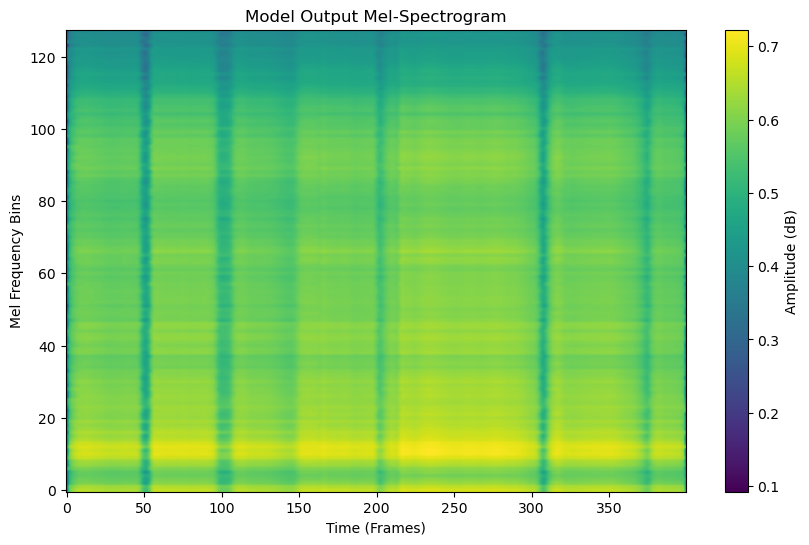

In [29]:
def plot_mel_spectrogram_direct(mel_spectrogram, title="Mel-Spectrogram"):
    """
    Plots the mel-spectrogram.
    
    Args:
        mel_spectrogram (torch.Tensor): The mel-spectrogram to plot.
        title (str): Title of the plot.
    """
    # Check the shape and reshape if necessary
    if len(mel_spectrogram.shape) == 4:  # [1, 128, 1, 400]
        mel_spectrogram = mel_spectrogram.squeeze(0).squeeze(1)  # Shape becomes [128, 400]
    elif len(mel_spectrogram.shape) == 3:  # [128, 1, 400]
        mel_spectrogram = mel_spectrogram.squeeze(1)  # Shape becomes [128, 400]
    elif len(mel_spectrogram.shape) != 2:  # Ensure it's [128, 400]
        raise ValueError(f"Invalid mel-spectrogram shape: {mel_spectrogram.shape}. Expected [128, 400].")

    # Plot the mel-spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(mel_spectrogram.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel("Time (Frames)")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Amplitude (dB)")
    plt.show()

# Example usage
plot_mel_spectrogram_direct(model_output, title="Model Output Mel-Spectrogram")

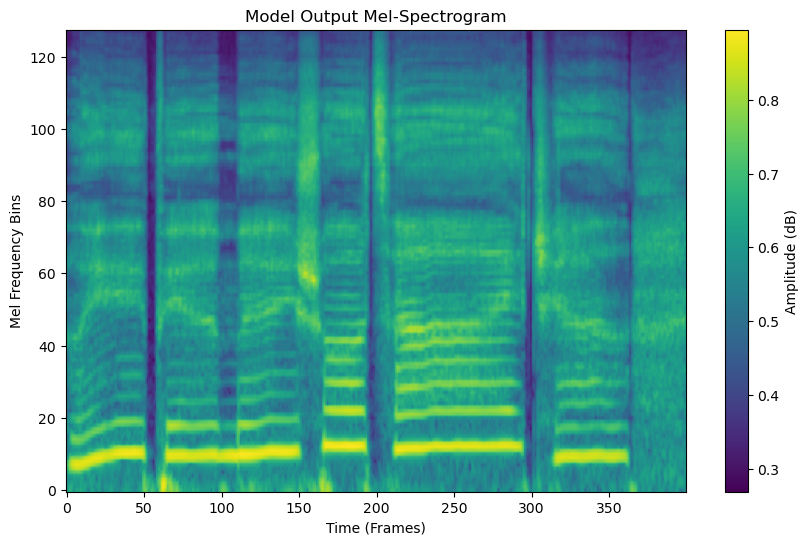

In [30]:
plot_mel_spectrogram_direct(dataset[0]["technique_mel"], title="Model Output Mel-Spectrogram")

In [ ]:
"""
# Loss function and optimizer
criterion = nn.MSELoss()  # Reconstruction loss
scales = [1, 2, 4]  # Downsampling factors for multi-scale loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    x = torch.randn(16, 1, 128, 400)  # Example input

    optimizer.zero_grad()

    # Forward pass
    recon, mu, logvar, enc_int, dec_int = model(x)

    # Compute VAE loss
    loss = model.vae_loss(x, recon, mu, logvar, enc_int, dec_int, scales=[1, 2, 4], criterion=nn.MSELoss())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
"""

In [12]:
def stft_loss(predicted, target, n_fft=1024, hop_length=256, win_length=1024):
    """
    Computes the STFT loss between the predicted and target signals.

    Args:
        predicted (torch.Tensor): Predicted mel-spectrogram of shape [batch_size, n_mels, timesteps].
        target (torch.Tensor): Target mel-spectrogram of shape [batch_size, n_mels, timesteps].
        n_fft (int): Number of FFT components.
        hop_length (int): Hop length for STFT.
        win_length (int): Window length for STFT.

    Returns:
        torch.Tensor: The STFT loss.
    """
    # Ensure the input has the correct shape
    if len(predicted.shape) != 3 or len(target.shape) != 3:
        raise ValueError(f"Invalid input shapes: predicted={predicted.shape}, target={target.shape}. Expected [batch_size, n_mels, timesteps].")

    # Compute STFT for predicted and target signals
    predicted_stft = torch.stft(predicted.flatten(start_dim=1), n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=False)
    target_stft = torch.stft(target.flatten(start_dim=1), n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=False)

    # Compute magnitude
    predicted_mag = torch.sqrt(predicted_stft.pow(2).sum(-1))
    target_mag = torch.sqrt(target_stft.pow(2).sum(-1))

    # Compute STFT loss
    loss = torch.nn.functional.mse_loss(predicted_mag, target_mag)

    return loss